<a href="https://colab.research.google.com/github/g-nyuk/Demand-Side_Fluctuation/blob/Varying-the-width-and-depth-of-investment/(Varying_W_D_of_compensation)Demand_Side_Fluctuationipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#INITIAL CONDITION - FIRM
INITIAL_CAPITAL = 100
INITIAL_PATHNUM = 1

In [4]:
#DEMAND-SIDE FLUCTUATION
INTERCEPT = 40
GROWTH= 0.1
AMPLITUDE = 20
PERIOD = 25
TIME_DURATION = 100

class DemandSide_Fluctuation:
    def __init__(self, intercept = INTERCEPT, growth = GROWTH, amplitude = AMPLITUDE, period = PERIOD, time_range = TIME_DURATION):
        self.time_range = time_range
        self.intercept = intercept
        self.growth = growth
        self.amplitude = amplitude
        self.period = period
        self.time, self.time_series = self.generate_time_series()

    def generate_time_series(self):
        time = np.linspace(0, self.time_range, 1000)
        time_series = self.growth * time + self.amplitude * np.sin(2 * np.pi / self.period * time) + self.intercept
        return time, time_series

    def get_value(self, t):
        return self.growth * t + self.amplitude * np.sin(2 * np.pi / self.period * t) + self.intercept

    def plot(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.time, self.time_series, label = f'Y = {self.growth}X + {self.amplitude}Sin(2π/{self.period}X) + {self.intercept}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

In [5]:
#COMPETION CONDITON
PROBABILITY = 0.25
COMPENSATION = 40
UNIT_EXPENDITURE = 10

class Firm:
    def __init__(self, name, demand, capital=INITIAL_CAPITAL, numPath=INITIAL_PATHNUM, unit_expenditure=UNIT_EXPENDITURE, compensation=COMPENSATION):
        self.name = name
        self.capital = capital
        self.numPath = numPath
        self.unit_expenditure = unit_expenditure
        self.compensation = compensation
        self.demand = demand
        self.bankrupt = False

    def invest(self, timestep):
        self.compensation = self.demand.get_value(timestep)

        if self.capital < self.unit_expenditure * self.numPath:
            self.bankrupt = True
            return 0

        self.capital -= self.unit_expenditure * self.numPath

        successes = sum(random.random() < PROBABILITY for _ in range(self.numPath))
        self.capital += successes * self.compensation

        if self.capital // 100 > self.numPath :
            self.numPath += 1

        if self.capital // 100 < self.numPath and self.numPath != 1 :
            self.numPath -= 1


        return successes

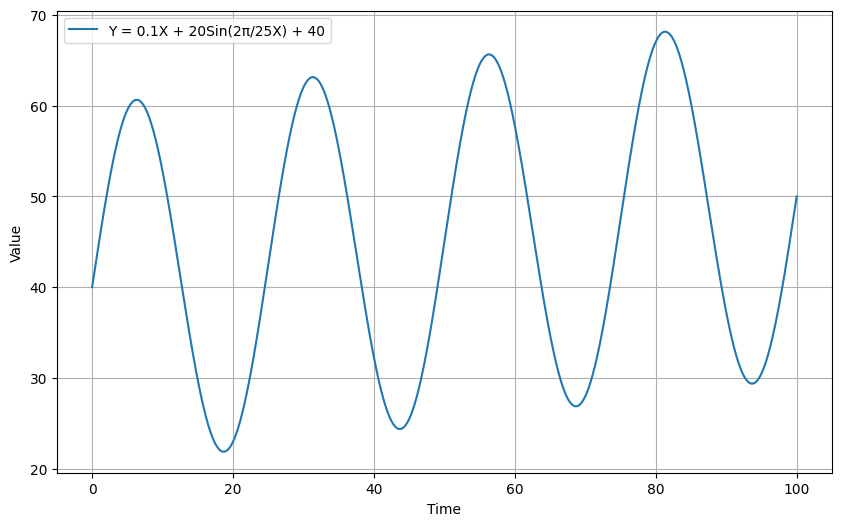

In [6]:
demand_condition = DemandSide_Fluctuation()
demand_condition.plot()

In [40]:
def single_simulation(num_firms = 2):
    firms = [Firm(f'Firm {chr(65+i)}', demand_condition) for i in range(num_firms)]
    data = []

    for timestep in range(TIME_DURATION):
        for firm in firms:
            if firm.bankrupt:
                continue
            successes = firm.invest(timestep)
            data.append({'timestep': timestep, 'firm': firm.name, 'successes': successes, 'capital': firm.capital, 'numPath': firm.numPath})

    df = pd.DataFrame(data)
    df = df.astype({'timestep': int, 'successes': int, 'capital': np.float64, 'numPath': int})

    bankrupt_firms = len([firm for firm in firms if firm.bankrupt])

    return df

In [44]:
df = single_simulation()

In [45]:
df[df['firm'] == 'Firm A']

,timestep,firm,successes,capital,numPath
0,0,Firm A,0,90.0,1
2,1,Firm A,0,80.0,1
4,2,Firm A,0,70.0,1
6,3,Firm A,0,60.0,1
8,4,Firm A,0,50.0,1
10,5,Firm A,0,40.0,1
12,6,Firm A,0,30.0,1
14,7,Firm A,0,20.0,1
16,8,Firm A,0,10.0,1
18,9,Firm A,0,0.0,1


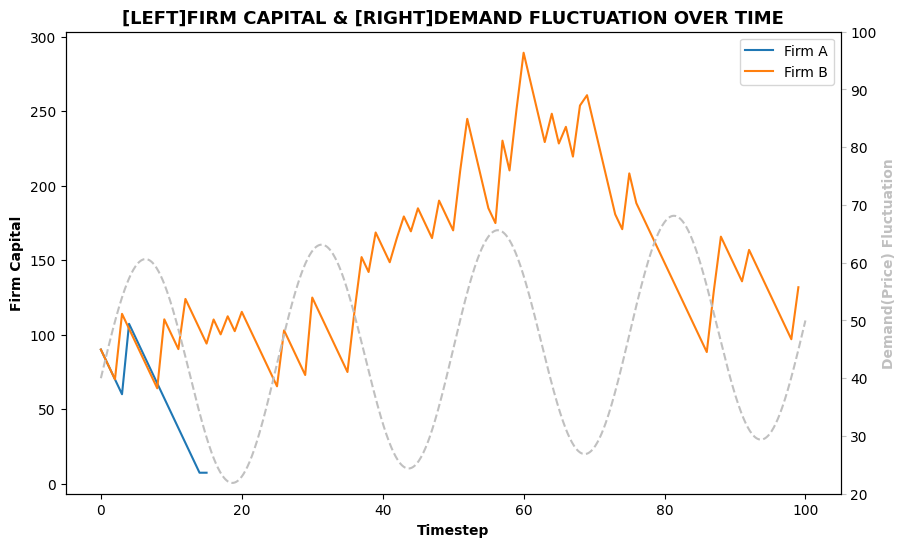

In [43]:
firm_a = df[df['firm'] == 'Firm A']
firm_b = df[df['firm'] == 'Firm B']

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()

ax1.plot(firm_a['timestep'], firm_a['capital'], label='Firm A')
ax1.plot(firm_b['timestep'], firm_b['capital'], label='Firm B')
ax1.set_xlabel('Timestep', fontweight = 'bold', fontsize = 10)
ax1.set_ylabel('Firm Capital', fontweight = 'bold', fontsize = 10)
ax1.tick_params(axis='y')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(demand_condition.time, demand_condition.time_series, '--', color = 'silver')
ax2.set_ylabel('Demand(Price) Fluctuation', fontweight = 'bold', color = 'silver', fontsize = 10)
ax2.set_ylim(20, 100)
ax2.tick_params(axis='y', color = 'silver')


plt.title('[LEFT]FIRM CAPITAL & [RIGHT]DEMAND FLUCTUATION OVER TIME', fontweight = 'heavy', fontsize = 13)
plt.show()

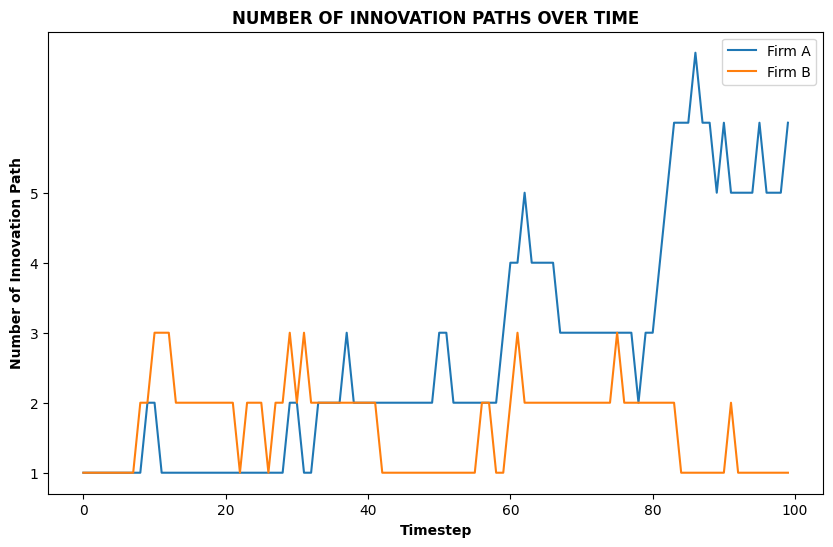

In [14]:
plt.figure(figsize=(10,6))
plt.plot(firm_a['timestep'], firm_a['numPath'], label='Firm A')
plt.plot(firm_b['timestep'], firm_b['numPath'], label='Firm B')

plt.xlabel('Timestep', fontweight = 'bold', fontsize = 10)
plt.ylabel('Number of Innovation Path',  fontweight = 'bold', fontsize = 10)
plt.legend()
plt.title('NUMBER OF INNOVATION PATHS OVER TIME', fontweight = 'heavy', fontsize = 12)
plt.yticks([1,2,3,4,5])
plt.show()

In [31]:
def run_simulation(num_firms):
    firms = [Firm(f'Firm {chr(65+i)}', demand_condition) for i in range(num_firms)]
    for timestep in range(TIME_DURATION):
        for firm in firms:
            if firm.bankrupt:
                continue
            firm.invest(timestep)

    bankrupt_firms = len([firm for firm in firms if firm.bankrupt])

    return bankrupt_firms

def survival_scenarios(number_of_iterations):
    both_survived = 0
    only_one_survived = 0
    both_bankrupt = 0
    total_surviving_firms = 0

    for _ in range(number_of_iterations):
        bankrupt_firms = run_simulation(2)  # Since we're considering scenarios for two firms
        surviving_firms = 2 - bankrupt_firms
        total_surviving_firms += surviving_firms
        if bankrupt_firms == 0:
            both_survived += 1
        elif bankrupt_firms == 1:
            only_one_survived += 1
        else:
            both_bankrupt += 1

    both_survived_rate = both_survived / number_of_iterations
    only_one_survived_rate = only_one_survived / number_of_iterations
    both_bankrupt_rate = both_bankrupt / number_of_iterations
    average_survival_rate = total_surviving_firms / (number_of_iterations * 2) # Since we have 2 firms per iteration

    return average_survival_rate, both_survived_rate, only_one_survived_rate, both_bankrupt_rate

In [38]:
avg_survival_rate, both_survived_rate, only_one_survived_rate, both_bankrupt_rate  = survival_scenarios(10000)
print(f'Both survived rate: {both_survived_rate * 100:.2f}%')
print(f'Only one survived rate: {only_one_survived_rate * 100:.2f}%')
print(f'Both bankrupt rate: {both_bankrupt_rate * 100:.2f}%')
print(f'Average survival rate: {avg_survival_rate * 100:.2f}%')

Both survived rate: 29.89%
Only one survived rate: 49.61%
Both bankrupt rate: 20.50%
Average survival rate: 54.70%
